In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# load data
data = pd.read_csv('hiring.csv')
# display data set
display(data.head())

# prepare data set
y = data['hired']
A = data['gender']
X = data.drop(['hired', 'gender'], axis=1)

# convert categorical gender to dummy variables
X[['female', 'male', 'non_binary']] = pd.get_dummies(A)

# split into train and test set
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, random_state=0, test_size=0.5)

# train classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)

,years_of_experience,test_score,interview_score,average_grade,gender,hired
0,1,2,2,6,male,0
1,1,1,1,6,female,0
2,2,2,2,6,female,0
3,3,1,2,7,male,0
4,2,1,2,6,male,0


LogisticRegression()

In [2]:
# compute metrics by group
from fairlearn.metrics import MetricFrame, selection_rate

mf = MetricFrame(
    metrics={"selection rate": selection_rate},
    y_true=y_test,  # is ignored
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall)

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

# compute demographic parity as the min ratio between groups
print("demographic parity ratio: %.2f" % mf.ratio(method="between_groups"))

,selection rate
gender,
female,0.148649
male,0.226300
non_binary,0.107843


Overall selection rate: 0.19
demographic parity difference: 0.12
demographic parity ratio: 0.48


In [3]:
from fairlearn.metrics import count

# compute metrics by group
mf = MetricFrame(
    metrics={
        "selection rate": selection_rate, 
        "count": count},
    y_true=y_test,  # is ignored
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
    control_features=X_test['test_score']
)

# display results
display(mf.by_group)
display(mf.difference())

selection rate  count
test_score gender                           
1          female            0.051282  195.0
           male              0.087571  354.0
           non_binary        0.046512   43.0
2          female            0.169591  171.0
           male              0.295337  193.0
           non_binary        0.108108   37.0
3          female            0.346154   78.0
           male              0.560748  107.0
           non_binary        0.227273   22.0

,selection rate,count
test_score,,
1,0.041059,311.0
2,0.187229,156.0
3,0.333475,85.0


In [4]:
from fairlearn.metrics import false_positive_rate, false_negative_rate, equalized_odds_difference

# compute metrics by group
mf = MetricFrame(
    metrics={
        'fpr' : false_positive_rate,
        'fnr' : false_negative_rate,
        },
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test
)

# display results
display(mf.by_group)
display(mf.difference())

# compute equalized odds difference directly
eod = equalized_odds_difference(
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test
)
print("equalized odds difference: %.2f" % eod)

,fpr,fnr
gender,,
female,0.040000,0.260870
male,0.055336,0.189189
non_binary,0.022727,0.357143


fpr    0.032609
fnr    0.167954
dtype: float64

equalized odds difference: 0.17


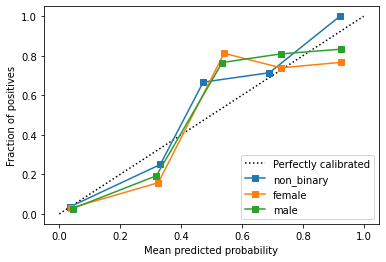

In [5]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# display calibration curves
ax = plt.gca()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for gender in ['non_binary', 'female', 'male']:
    CalibrationDisplay.from_predictions(
        y_true=y_test[A_test==gender],
        y_prob=lr.predict_proba(X_test[A_test==gender])[:,1],
        n_bins=5,
        ax=ax, 
        label=gender)
plt.show()

In [6]:
from sklearn.metrics import precision_score 

# first, we define a function to compute the negative predictie value
def negative_predictive_value_score(y_true, y_pred, **kwargs):
    """
    NPV is not in scikit-learn, but is the same as PPV but with 0 and 1 swapped.
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

# compute metrics
mf = MetricFrame(
    metrics={
        "positive predictive value": precision_score,
        "negative predictive value": negative_predictive_value_score,
    },
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
)
display(mf.by_group)

,positive predictive value,negative predictive value
gender,,
female,0.772727,0.952381
male,0.810811,0.944664
non_binary,0.818182,0.945055
